In [ ]:
import os
import torch
import tensorrt as trt
import onnx
import onnxruntime

from vit_models.model import ViTPose
from configs.ViTPose_coco import model_small as model_cfg

# ONNX to TRT

In [24]:
def export_engine(onnx, im, file, half, dynamic, workspace=4, verbose=False, prefix='Tensorrt'):
    logger = trt.Logger(trt.Logger.INFO)
    if verbose:
        logger.min_severity = trt.Logger.Severity.VERBOSE

    builder = trt.Builder(logger)
    config = builder.create_builder_config()
    config.max_workspace_size = workspace * 1 << 30
    # config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, workspace << 30)  # fix TRT 8.4 deprecation notice

    flag = (1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    network = builder.create_network(flag)
    parser = trt.OnnxParser(network, logger)
    if not parser.parse_from_file(str(onnx)):
        raise RuntimeError(f'failed to load ONNX file: {onnx}')

    inputs = [network.get_input(i) for i in range(network.num_inputs)]
    outputs = [network.get_output(i) for i in range(network.num_outputs)]
    for inp in inputs:
        print(f'{prefix} input "{inp.name}" with shape{inp.shape} {inp.dtype}')
    for out in outputs:
        print(f'{prefix} output "{out.name}" with shape{out.shape} {out.dtype}')

    if dynamic:
        if im.shape[0] <= 1:
            print(f'{prefix} WARNING ⚠️ --dynamic model requires maximum --batch-size argument')
        profile = builder.create_optimization_profile()
        for inp in inputs:
            profile.set_shape(inp.name, (1, *im.shape[1:]), (max(1, im.shape[0] // 2), *im.shape[1:]), im.shape)
        config.add_optimization_profile(profile)

    print(f'{prefix} building FP{16 if builder.platform_has_fast_fp16 and half else 32} engine')
    if builder.platform_has_fast_fp16 and half:
        config.set_flag(trt.BuilderFlag.FP16)
    with builder.build_engine(network, config) as engine, open(file, 'wb') as t:
        t.write(engine.serialize())
    return True

In [30]:
ONNX_PATH = "ckpts/vitpose-25-h_onnx/vitpose-25-h.onnx"
TRT_PATH = ONNX_PATH.replace('.onnx', '.engine')
C, H, W = (3, 256, 192)

input_names = ["input_0"]
output_names = ["output_0"]

device = next(model.parameters()).device
inputs = torch.randn(1, C, H, W).to(device)

dynamic_axes = {'input_0' : {0 : 'batch_size'},
                'output_0' : {0 : 'batch_size'}}

In [31]:
export_engine(ONNX_PATH, inputs, TRT_PATH, False, True, verbose=False)

[05/04/2023-11:25:45] [TRT] [I] The logger passed into createInferBuilder differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.

[05/04/2023-11:25:45] [TRT] [I] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 4253, GPU 1346 (MiB)
[05/04/2023-11:25:45] [TRT] [I] ----------------------------------------------------------------
[05/04/2023-11:25:45] [TRT] [I] Input filename:   ckpts/vitpose-25-h_onnx/vitpose-25-h.onnx
[05/04/2023-11:25:45] [TRT] [I] ONNX IR version:  0.0.6
[05/04/2023-11:25:45] [TRT] [I] Opset version:    11
[05/04/2023-11:25:45] [TRT] [I] Producer name:    pytorch
[05/04/2023-11:25:45] [TRT] [I] Producer version: 1.12.1
[05/04/2023-11:25:45] [TRT] [I] Domain:           
[05/04/2023-11:25:45] [TRT] [I] Model version:    0
[05/04/2023-11:25:45] [TRT] [I] Doc string:       
[05/04/2023-11:25:45] [TRT] [I] ---------------------------------------------

/tmp/ipykernel_3056/1333021398.py:11: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = workspace * 1 << 30


Tensorrt input "input_0" with shape(-1, 3, 256, 192) DataType.FLOAT
Tensorrt output "output_0" with shape(-1, 25, 64, 48) DataType.FLOAT
Tensorrt WARNING ⚠️ --dynamic model requires maximum --batch-size argument
Tensorrt building FP32 engine


/tmp/ipykernel_3056/1333021398.py:38: DeprecationWarning: Use build_serialized_network instead.
  with builder.build_engine(network, config) as engine, open(file, 'wb') as t:


[05/04/2023-11:26:01] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +1, GPU +10, now: CPU 6720, GPU 1356 (MiB)
[05/04/2023-11:26:01] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 6720, GPU 1364 (MiB)
[05/04/2023-11:26:01] [TRT] [I] Local timing cache in use. Profiling results in this builder pass will not be stored.
[05/04/2023-11:26:16] [TRT] [I] Detected 1 inputs and 1 output network tensors.
[05/04/2023-11:26:19] [TRT] [I] Total Host Persistent Memory: 6448
[05/04/2023-11:26:19] [TRT] [I] Total Device Persistent Memory: 1536
[05/04/2023-11:26:19] [TRT] [I] Total Scratch Memory: 13172736
[05/04/2023-11:26:19] [TRT] [I] [MemUsageStats] Peak memory usage of TRT CPU/GPU memory allocators: CPU 0 MiB, GPU 0 MiB
[05/04/2023-11:26:19] [TRT] [I] [BlockAssignment] Algorithm ShiftNTopDown took 0.031095ms to assign 3 blocks to 7 nodes requiring 17301504 bytes.
[05/04/2023-11:26:19] [TRT] [I] Total Activation Memory: 17301504
[05/04/2023-11:26:19] [TRT] [I] [MemUsageChan

True

# Inference with TRT model

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pycuda.driver as cuda
import pycuda.autoinit
import utils_engine as engine_utils # TRT Engine creation/save/load utils

from time import time
from PIL import Image
from torchvision.transforms import transforms

from vit_utils.visualization import draw_points_and_skeleton, joints_dict
from vit_utils.dist_util import get_dist_info, init_dist
from vit_utils.top_down_eval import keypoints_from_heatmaps

TRT_PATH = "ckpts/vitpose-25-b.engine"

# SETUP TRT
logger = trt.Logger(trt.Logger.ERROR)
trt_runtime = trt.Runtime(logger)

print("Loading cached TensorRT engine from {}".format(TRT_PATH))
trt_engine = engine_utils.load_engine(trt_runtime, TRT_PATH)

# This allocates memory for network inputs/outputs on both CPU and GPU
inputs, outputs, bindings, stream = engine_utils.allocate_buffers(trt_engine)

# Execution context is needed for inference
context = trt_engine.create_execution_context()

Loading cached TensorRT engine from ckpts/vitpose-25-b.engine
input_0
output_0


>>> Output size: (1, 25, 64, 48) ---> 0.0242 sec. elapsed [ 41.3 fps]



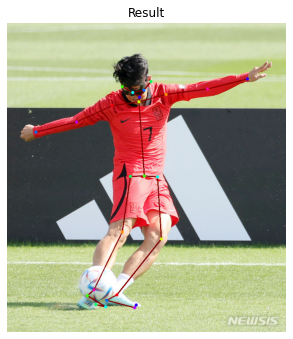

In [25]:
# Prepare input data
IMG_PATH = "examples/img1.jpg"
img = cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB)
org_h, org_w = img.shape[:2]
img_input = cv2.resize(img, (192, 256), interpolation=cv2.INTER_LINEAR)
img_input = img_input.astype(np.float32).transpose(2, 0, 1)[None, ...] / 255

# Copy it into appropriate place into memory
# (inputs was returned earlier by allocate_buffers())
np.copyto(inputs[0].host, img_input.ravel())

# Feed to model
tic = time()
bs = 1
# Fetch output from the model
heatmaps = engine_utils.do_inference(
    context, bindings=bindings, inputs=inputs,
    outputs=outputs, stream=stream)[0]
heatmaps = heatmaps.reshape((1, 25, 64, 48))

elapsed_time = time()-tic
print(f">>> Output size: {heatmaps.shape} ---> {elapsed_time:.4f} sec. elapsed [{elapsed_time**-1: .1f} fps]\n")    

points, prob = keypoints_from_heatmaps(heatmaps=heatmaps, center=np.array([[org_w//2, org_h//2]]), scale=np.array([[org_w, org_h]]),
                                        unbiased=True, use_udp=True)
points = np.concatenate([points[:, :, ::-1], prob], axis=2)

# Visualization 
for pid, point in enumerate(points):
    img = draw_points_and_skeleton(img.copy(), point, joints_dict()['coco']['skeleton'], person_index=pid,
                                    points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                    points_palette_samples=10, confidence_threshold=0.4)
    
    plt.figure(figsize=(5,10))
    plt.imshow(img)
    plt.title("Result")
    plt.axis('off')
    plt.show()